# Setup

In [189]:
### Packages import
import os
import gc
import time
start_time = time.time()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from src.cuda_checker import cuda_torch_check, memory_checker

### My modules import
from src.data_loader import argObj, data_loaders_stimuli_fmri
from src import image_preprocessing
from src.feature_extraction import model_loader, fit_pca, pca_batch_calculator, extract_and_pca_features
from src.encoding import linear_regression, compute_perason_numpy
from src.evaluation_metrics import median_squared_noisenorm_correlation

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
from src.visualize import histogram, box_plot

from nilearn import datasets
from nilearn import plotting
from nilearn import surface

### Cuda setup and check
# import torch
# Select the device to run the model on
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
# Check if cuda is available
device = torch.device(device)
cuda_torch_check()

Check if GPU is available and if torch is using it ..


Torch Cuda is available?
True
Torch Cuda device count is :
1
Torch Cuda current device is :
0
Torch Cuda device is :
NVIDIA GeForce RTX 3070 Laptop GPU
Pytorch version：
1.13.0
CUDA Version: 
11.6
cuDNN version is :
8302




In [2]:
### Parameters definition
train_percentage = 90 # X% of the training data will be used for training, (100-X)% for validation
transform = image_preprocessing.imagenet_transform_alt

batch_size = 64
pca_component = 512
min_pca_batch_size = pca_component * 2 # pca_component * 2

feature_model_type = "alexnet" #@param ["alexnet", "vgg16", "vgg19_bn, ""efficientnetb2", "efficientnetb2lib"]
model_layer = "features.2"
regression_type = "linear" #@param ["linear", "ridge"]

save_predictions = False

alpha_l = 1e6
alpha_r = 1e6
grid_search = False

subj = 1
noise_norm_corr_dict = {}

### Path definition
if isinstance(model_layer, list):
    model_layer_full = '+'.join(model_layer)
else:
    model_layer_full = model_layer
submission_name = f'{feature_model_type}_{model_layer}-pca_{pca_component}-{regression_type}-alpha_{alpha_l}'

# Data folder definition
data_home_dir = '../Datasets/Biomedical'
data_dir = '../Datasets/Biomedical/algonauts_2023_challenge_data'
# Used to save the prediction of saved model
parent_submission_dir = f'./files/submissions/{submission_name}'
images_submission_dir = f"./files/submissions/imgs/{submission_name}"
ncsnr_dir = '../Datasets/Biomedical/algonauts_ncsnr'
images_trials_dir = '../Datasets/Biomedical/algonauts_train_images_trials'

In [3]:
submission_name

'alexnet_features.2-pca_512-linear-alpha_1000000.0'

In [4]:
print(submission_name + "\n")
print('############################ Subject: ' + str(subj) + ' ############################ \n')
# Definining paths to data and submission directories ##
args = argObj(subj, data_home_dir, data_dir, parent_submission_dir, ncsnr_dir, images_trials_dir, images_submission_dir) 
# Obtain the indices of the training, validation and test data
idxs_train, idxs_val, idxs_test, train_imgs_paths, test_imgs_paths = args.images_idx_splitter(train_percentage)

# Defining the images data loaderds
data_loaders = data_loaders_stimuli_fmri(idxs_train, 
                                            idxs_val, 
                                            idxs_test, 
                                            train_imgs_paths, 
                                            test_imgs_paths,
                                            lh_fmri_path = args.lh_fmri,
                                            rh_fmri_path = args.rh_fmri)


alexnet_features.2-pca_512-linear-alpha_1000000.0

############################ Subject: 1 ############################ 

## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus images: 984
Test stimulus images: 159




# Data Exploration (subj 1)

## Subjects Data Exploration

In [4]:
for i in range(1,9):
    args = argObj(subj, data_home_dir, data_dir, parent_submission_dir, ncsnr_dir, images_trials_dir, images_submission_dir) 
    # Obtain the indices of the training, validation and test data
    idxs_train, idxs_val, idxs_test, train_imgs_paths, test_imgs_paths = args.images_idx_splitter(train_percentage)

    # Defining the images data loaderds
    data_loaders = data_loaders_stimuli_fmri(idxs_train, 
                                                idxs_val, 
                                                idxs_test, 
                                                train_imgs_paths, 
                                                test_imgs_paths,
                                                lh_fmri_path = args.lh_fmri,
                                                rh_fmri_path = args.rh_fmri)

    lh_fmri_train, lh_fmri_val, rh_fmri_train, rh_fmri_val = data_loaders.fmri_splitter()
    print(f"Soggetto {i}, lh, shape:", np.shape(np.vstack((lh_fmri_train, lh_fmri_val))))
    print(f"Soggetto {i}, rh, shape:", np.shape(np.vstack((rh_fmri_train, rh_fmri_val))))

## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus images: 984
Test stimulus images: 159


Soggetto 1, lh, shape: (9841, 19004)
Soggetto 1, rh, shape: (9841, 20544)
## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus images: 984
Test stimulus images: 159


Soggetto 2, lh, shape: (9841, 19004)
Soggetto 2, rh, shape: (9841, 20544)
## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus images: 984
Test stimulus images: 159


Soggetto 3, lh, shape: (9841, 19004)
Soggetto 3, rh, shape: (9841, 20544)
## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus images: 984
Test stimulus images: 159


Soggetto 4, lh, shape: (9841, 19004)
Soggetto 4, rh, shape: (9841, 20544)
## Stimulus Images Loading: Info
Total train images: 9841
Training stimulus images: 8857
Validation stimulus

## Bold Responses

In [5]:
import pandas as pd
row_labels = ['img'+str(i+1) for i in range(lh_fmri_train.shape[0])]
col_labels = ['v'+str(i+1) for i in range(lh_fmri_train.shape[1])]

# Creazione del DataFrame
df = pd.DataFrame(lh_fmri_train, index=row_labels, columns=col_labels)

In [ ]:
df.head()

## 1) ROI-related .npy files and 2) challenge-to-fsaverage-space .npy map

### Loading Files

In [5]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []

rh_challenge_roi_files_name_only = [s.split(".", 1)[1].replace("_challenge_space.npy", "") for s in rh_challenge_roi_files]

for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]


In [6]:
### fsaverage space maps (same code as above, but for fsaverage space)

lh_fsaverage_roi_files = ['lh.prf-visualrois_fsaverage_space.npy',
    'lh.floc-bodies_fsaverage_space.npy', 'lh.floc-faces_fsaverage_space.npy',
    'lh.floc-places_fsaverage_space.npy', 'lh.floc-words_fsaverage_space.npy',
    'lh.streams_fsaverage_space.npy']
rh_fsaverage_roi_files = ['rh.prf-visualrois_fsaverage_space.npy',
    'rh.floc-bodies_fsaverage_space.npy', 'rh.floc-faces_fsaverage_space.npy',
    'rh.floc-places_fsaverage_space.npy', 'rh.floc-words_fsaverage_space.npy',
    'rh.streams_fsaverage_space.npy']
lh_fsaverage_rois = []
rh_fsaverage_rois = []

rh_fsaverage_roi_files_name_only = [s.split(".", 1)[1].replace("_fsaverage_space.npy", "") for s in rh_fsaverage_roi_files]

for r in range(len(lh_fsaverage_roi_files)):
    lh_fsaverage_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_fsaverage_roi_files[r])))
    rh_fsaverage_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_fsaverage_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_fsaverage_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_fsaverage_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_fsaverage_rois[r1] == r2[0])[0]

### Per Class - ROI Indicies/Name Maps

Challenge Space

In [6]:
for i, elemento in enumerate(roi_name_maps):
    print("(RH and LH) ROI Class", i, f"({rh_challenge_roi_files_name_only[i]})", elemento)

(RH and LH) ROI Class 0 (prf-visualrois) {0: 'Unknown', 1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4'}
(RH and LH) ROI Class 1 (floc-bodies) {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'}
(RH and LH) ROI Class 2 (floc-faces) {0: 'Unknown', 1: 'OFA', 2: 'FFA-1', 3: 'FFA-2', 4: 'mTL-faces', 5: 'aTL-faces'}
(RH and LH) ROI Class 3 (floc-places) {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'}
(RH and LH) ROI Class 4 (floc-words) {0: 'Unknown', 1: 'OWFA', 2: 'VWFA-1', 3: 'VWFA-2', 4: 'mfs-words', 5: 'mTL-words'}
(RH and LH) ROI Class 5 (streams) {0: 'Unknown', 1: 'early', 2: 'midventral', 3: 'midlateral', 4: 'midparietal', 5: 'ventral', 6: 'lateral', 7: 'parietal'}


fsaverage space

In [7]:
for i, elemento in enumerate(roi_name_maps):
    print("(RH and LH) ROI Class", i, f"({rh_fsaverage_roi_files_name_only[i]})", elemento)

(RH and LH) ROI Class 0 (prf-visualrois) {0: 'Unknown', 1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4'}
(RH and LH) ROI Class 1 (floc-bodies) {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'}
(RH and LH) ROI Class 2 (floc-faces) {0: 'Unknown', 1: 'OFA', 2: 'FFA-1', 3: 'FFA-2', 4: 'mTL-faces', 5: 'aTL-faces'}
(RH and LH) ROI Class 3 (floc-places) {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'}
(RH and LH) ROI Class 4 (floc-words) {0: 'Unknown', 1: 'OWFA', 2: 'VWFA-1', 3: 'VWFA-2', 4: 'mfs-words', 5: 'mTL-words'}
(RH and LH) ROI Class 5 (streams) {0: 'Unknown', 1: 'early', 2: 'midventral', 3: 'midlateral', 4: 'midparietal', 5: 'ventral', 6: 'lateral', 7: 'parietal'}


### Per Class - Vertex/ROI Indicies maps

challenge space

In [8]:
for i, elemento in enumerate(lh_challenge_rois):
    print("(LH) ROI Class", i, ":" ,elemento, "shape:", elemento.shape, f"({rh_challenge_roi_files_name_only[i]})")

(LH) ROI Class 0 : [0 0 0 ... 0 0 0] shape: (19004,) (prf-visualrois)
(LH) ROI Class 1 : [0 0 0 ... 0 0 0] shape: (19004,) (floc-bodies)
(LH) ROI Class 2 : [0 0 0 ... 0 0 0] shape: (19004,) (floc-faces)
(LH) ROI Class 3 : [0 3 1 ... 0 0 0] shape: (19004,) (floc-places)
(LH) ROI Class 4 : [0 0 0 ... 0 0 0] shape: (19004,) (floc-words)
(LH) ROI Class 5 : [3 0 7 ... 5 5 5] shape: (19004,) (streams)


In [9]:
for i, elemento in enumerate(rh_challenge_rois):
    print("(RH) ROI Class", i, ":" ,elemento, "shape:", elemento.shape, f"({rh_challenge_roi_files_name_only[i]})")

(RH) ROI Class 0 : [4 0 0 ... 0 0 0] shape: (20544,) (prf-visualrois)
(RH) ROI Class 1 : [0 0 1 ... 3 3 3] shape: (20544,) (floc-bodies)
(RH) ROI Class 2 : [0 0 0 ... 0 0 0] shape: (20544,) (floc-faces)
(RH) ROI Class 3 : [0 1 0 ... 0 0 0] shape: (20544,) (floc-places)
(RH) ROI Class 4 : [0 0 0 ... 3 3 3] shape: (20544,) (floc-words)
(RH) ROI Class 5 : [1 7 6 ... 5 5 5] shape: (20544,) (streams)


fsaverage space

In [10]:
for i, elemento in enumerate(lh_fsaverage_rois):
    print("(LH) ROI Class", i, ":" ,elemento, "shape:", elemento.shape, f"({rh_fsaverage_roi_files_name_only[i]})")

(LH) ROI Class 0 : [0 0 0 ... 0 0 0] shape: (163842,) (prf-visualrois)
(LH) ROI Class 1 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-bodies)
(LH) ROI Class 2 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-faces)
(LH) ROI Class 3 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-places)
(LH) ROI Class 4 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-words)
(LH) ROI Class 5 : [0 0 0 ... 0 0 0] shape: (163842,) (streams)


In [11]:
for i, elemento in enumerate(rh_fsaverage_rois):
    print("(RH) ROI Class", i, ":" ,elemento, "shape:", elemento.shape, f"({rh_fsaverage_roi_files_name_only[i]})")

(RH) ROI Class 0 : [0 0 0 ... 0 0 0] shape: (163842,) (prf-visualrois)
(RH) ROI Class 1 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-bodies)
(RH) ROI Class 2 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-faces)
(RH) ROI Class 3 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-places)
(RH) ROI Class 4 : [0 0 0 ... 0 0 0] shape: (163842,) (floc-words)
(RH) ROI Class 5 : [0 0 0 ... 0 0 0] shape: (163842,) (streams)


### **fsaverage to challenge** space maps

In [7]:
hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

In [55]:
print(fsaverage_all_vertices[30:40], "Shape", fsaverage_all_vertices.shape)

[0 0 1 0 1 0 0 0 0 0] Shape (163842,)


Or for **both hemisphere**

In [ ]:
fsaverage_all_vertices = {}
for hemisphere in hemispheres:
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices[f'{hemisphere[0]}h'] = np.load(roi_dir)

## .nii nilearn data

### Importing Freesurfer fsaverage surface maps

Download the Freesurfer fsaverage surface.

In [184]:
hemisphere = "left" #@param ['left', 'right'] {allow-input: true}

In [132]:
args.fsaverage_surface_dir

'../Datasets/Biomedical\\fsaverage_surface'

I obtained the following dictionary of path names for the fsaverage surface files:
- See https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_surf_fsaverage.html

In [133]:
fsaverage = datasets.fetch_surf_fsaverage(mesh = 'fsaverage', data_dir = args.fsaverage_surface_dir)
fsaverage

{'area_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\area_left.gii.gz',
 'area_right': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\area_right.gii.gz',
 'curv_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\curv_left.gii.gz',
 'curv_right': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\curv_right.gii.gz',
 'flat_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\flat_left.gii.gz',
 'flat_right': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\flat_right.gii.gz',
 'infl_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\infl_left.gii.gz',
 'infl_right': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\infl_right.gii.gz',
 'pial_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\pial_left.gii.gz',
 'pial_right': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\pial_right.gii.gz',
 'sphere_left': '../Datasets/Biomedical\\fsaverage_surface\\fsaverage\\sphere_left.gii.gz',
 'sphere_right': '

Parte di questi file (<strong>pial, infl, flat, sphere, white</strong>) sono delle <strong>surface mesh geometry</strong>, ovvero liste di <u>due array numpy</u>:
- `*_surface[0]` sono array (163842, 3) delle coordinate 3d del voxel del fsaverage
	- Array di tutti i vertici con le loro posizioni (coordinate 3d)
- `*_surface[1]` sono array (302172, 3) degli indici delle mesh faces (into coords) → non servono
	- Descrive le facce dei triangoli
	- Ogni elmento indica quali vertici (indice nell’altro vettore) collegare per fare un triangolo

Altri come <strong>sulc, area, curve</strong> forniscono invece informazioni aggiuntive su ogni vertice, ma non sono coordinate 3d come le superfici.

### Various form of fsaverage surfaces: exploration and visualization

We'll use [plotting.view_surf](https://nilearn.github.io/dev/modules/generated/nilearn.plotting.view_surf.html) to visualize:
- surf_mesh -> mesh da plottare -> va passato un array di coordinate
- surf_map -> valori da plottare per ognuno dei vertici plottati (es. valore di attivazione bold)
- bg_map -> immagine di sfondo, una texture. Tipicamente si usa `sulc_` surfaces così da avere uno shader realistico delle convoluzioni della corteccia

#### Sulc Surfaces

- Semplice texture monodimensionale
- Per ogni punto indica la sua distanza dalla calotta cranica
- Funge da texture monocromatica, associa ad ogni punto un colore (-2,2) (bianco, nero) che ne manifesti la prodondità
- Si usa come bg map

In [185]:
sulc_surface = surface.load_surf_data(fsaverage['sulc_'+hemisphere])
sulc_surface.shape

(163842,)

#### Pial Surfaces

rappresentazione della superficie corticale del cervello che segue la convoluzione dei solchi cerebrali

In [122]:
pial_surface = surface.load_surf_data(fsaverage['pial_'+hemisphere])

c:\Users\giorg\miniconda3\envs\algonauts_test\lib\site-packages\nilearn\surface\surface.py:679: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [13]:
print(pial_surface[0][:3])
print(pial_surface[0].shape)

[[-38.83455   -19.019356   66.90841  ]
 [-16.554127  -69.25585    60.977936 ]
 [ -9.5535755  -8.218807   46.25186  ]]
(163842, 3)


Plot di tutti i vertici della challenge space, dato il fsaverage space

In [ ]:
view = plotting.view_surf(
    surf_mesh=fsaverage['pial_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=hemisphere+' hemisphere'
    )
view

In [193]:
pd.DataFrame(pial_surface[0], columns=['x', 'y', 'z'], index=['v'+str(i+1) for i in range(len(pial_surface[0]))]).head(5)

,x,y,z
v1,28.357803,-12.419641,60.664833
v2,31.904566,-48.571194,44.225121
v3,64.559166,-8.603093,30.354609
v4,40.097095,43.175636,26.873529
v5,11.737663,22.975672,31.361729


#### Inflated Pial Surface

 L'inflated pial surface è una rappresentazione della superficie corticale che è stata "gonfiata" o "sbiancata" per semplificare la visualizzazione delle strutture corticali, per visualizzare in modo più dettagliato le regioni corticali e le loro relazioni spaziali.

In [186]:
infl_surface = surface.load_surf_data(fsaverage['infl_'+hemisphere])

c:\Users\giorg\miniconda3\envs\algonauts_test\lib\site-packages\nilearn\surface\surface.py:679: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [190]:
pd.DataFrame(infl_surface[0], columns=['x', 'y', 'z'], index=['v'+str(i+1) for i in range(len(infl_surface[0]))]).head(5)

,x,y,z
v1,-5.880375,2.493593,57.621799
v2,16.480145,-64.233917,54.906570
v3,30.061890,16.557844,43.149609
v4,5.344918,92.305893,13.215897
v5,-36.142063,24.777468,-2.782296


In [187]:
print(infl_surface[0][:3])
print(infl_surface[0].shape)

[[ -5.880375    2.4935925  57.6218   ]
 [ 16.480145  -64.23392    54.90657  ]
 [ 30.06189    16.557844   43.14961  ]]
(163842, 3)


Plot di tutti i vertici della challenge space, dato il fsaverage space

In [ ]:
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

#### Sphere Surfaces

Spherical mapping of cortical surface meshes provides a more convenient and accurate space for cortical surface registration and analysis

In [195]:
sphere_surface = surface.load_surf_data(fsaverage['sphere_'+hemisphere])

c:\Users\giorg\miniconda3\envs\algonauts_test\lib\site-packages\nilearn\surface\surface.py:679: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [200]:
pd.DataFrame(sphere_surface[0], columns=['x', 'y', 'z'], index=['v'+str(i+1) for i in range(len(sphere_surface[0]))]).head(5)

,x,y,z
v1,0.000000,0.000000,100.000000
v2,27.639999,-85.070000,44.720001
v3,89.440002,0.000000,44.720001
v4,27.639999,85.070000,44.720001
v5,-72.360001,52.569996,44.720001


In [201]:
print(sphere_surface[0][:3])
print(sphere_surface[0].shape)

[[  0.     0.   100.  ]
 [ 27.64 -85.07  44.72]
 [ 89.44   0.    44.72]]
(163842, 3)


Plot di tutti i vertici della challenge space, dato il fsaverage space

In [ ]:
view = plotting.view_surf(
    surf_mesh=fsaverage['sphere_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=hemisphere+' hemisphere'
    )
view

#### Flat Surface

flattened mapping of _cortical surface_ meshes

In [205]:
flat_surface = surface.load_surf_data(fsaverage['flat_'+hemisphere])

c:\Users\giorg\miniconda3\envs\algonauts_test\lib\site-packages\nilearn\surface\surface.py:679: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [206]:
pd.DataFrame(flat_surface[0], columns=['x', 'y', 'z'], index=['v'+str(i+1) for i in range(len(flat_surface[0]))]).head(5)

,x,y,z
v1,-4.498650,69.709900,0.0
v2,78.359352,61.859711,0.0
v3,-30.974064,116.890541,0.0
v4,-82.647675,39.266258,0.0
v5,-14.832266,9.171709,0.0


In [207]:
print(flat_surface[0][:3])
print(flat_surface[0].shape)

[[ -4.4986496  69.7099      0.       ]
 [ 78.35935    61.85971     0.       ]
 [-30.974064  116.89054     0.       ]]
(163842, 3)


Plot di tutti i vertici della challenge space, dato il fsaverage space

In [ ]:
view = plotting.view_surf(
    surf_mesh=fsaverage['flat_'+hemisphere],
    surf_map=fsaverage_all_vertices,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

#### White Sufaces

In [ ]:
view = plotting.view_surf(
    surf_mesh=fsaverage['white_'+hemisphere],
    surf_map=fsaverage_roi,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

## **ROI and ROI classes selection/masks** (in each hemisphere, space, ROI class and ROI)

### List of all hemishpere ans ROIs

In [216]:
hemispheres = ['left', 'right']
rois = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
roi_classes = ['prf-visualrois', 'floc-bodies', 'floc-faces', 'floc-places', 'floc-words', 'streams']


### Define a dictionary cointaining: **challenge to fsaverage maps for lh and rh**

In [413]:
# Mask of all vertices in challenge space of the selected hemisphere
fsaverage_all_vertices = {}
for hemisphere in hemispheres:
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices[f'{hemisphere[0]}h'] = np.load(roi_dir)

In [414]:
fsaverage_all_vertices

{'lh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'rh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

### Import **Per Class - Vertex/ROI Indicies maps** for every **ROI class** `*(left/right)_*(fsaverage/challenge)_roi_classes`

In [267]:
# ROI classes labels *_*_roi_classes
left_fsaverage_roi_classes = {}
left_roi_maps = {}
right_fsaverage_roi_classes = {}
right_roi_maps = {}

left_challenge_roi_classes = {}
left_challenge_roi_maps = {}
right_challenge_roi_classes = {}
right_challenge_roi_maps = {}

# Loading challe
for roi_class in roi_classes:
    
    # Mapping is the same for both hemispheres and space
    roi_map_dir = os.path.join(args.roi_dir,
        'mapping_'+roi_class+'.npy')
    
    # fsaverage array masks (whith numbers)
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[0][0]+'h.'+roi_class+'_fsaverage_space.npy')
    left_fsaverage_roi_classes[roi_class] = np.load(roi_class_dir)
    left_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()
    
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[1][0]+'h.'+roi_class+'_fsaverage_space.npy')
    right_fsaverage_roi_classes[roi_class] = np.load(roi_class_dir)
    right_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()
    
    # challenge array masks
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[0][0]+'h.'+roi_class+'_challenge_space.npy')
    left_challenge_roi_classes[roi_class] = np.load(roi_class_dir)
    left_challenge_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()
    
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[1][0]+'h.'+roi_class+'_challenge_space.npy')
    right_challenge_roi_classes[roi_class] = np.load(roi_class_dir)
    right_challenge_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()

### Create a **binary** fsaverage-space and challenge-space **mask** for voxel of specific **ROI class** (for every ROI in every hemisphere and space) `*(left/right)_*(fsaverage/challenge)_roi_classes_masks`

In [268]:
left_fsaverage_roi_classes_masks = {}
right_fsaverage_roi_classes_masks = {}
left_challenge_roi_classes_masks = {}
right_challenge_roi_classes_masks = {}

for roi_class in roi_classes:
    left_fsaverage_roi_classes_masks[roi_class] = np.where(left_fsaverage_roi_classes[roi_class] != 0, 1, 0)
    right_fsaverage_roi_classes_masks[roi_class] = np.where(right_fsaverage_roi_classes[roi_class] != 0, 1, 0)
    left_challenge_roi_classes_masks[roi_class] = np.where(left_challenge_roi_classes[roi_class] != 0, 1, 0)
    right_challenge_roi_classes_masks[roi_class] = np.where(right_challenge_roi_classes[roi_class] != 0, 1, 0) 

Here how to select the mask for a specific ROI class of a certain hemisphere

In [275]:
left_fsaverage_roi_classes_masks["prf-visualrois"]

array([0, 0, 0, ..., 0, 0, 0])

In [279]:
for roi_class in roi_classes:
    print(roi_class, left_fsaverage_roi_classes_masks[roi_class], right_fsaverage_roi_classes_masks[roi_class].shape)

prf-visualrois [0 0 0 ... 0 0 0] (163842,)
floc-bodies [0 0 0 ... 0 0 0] (163842,)
floc-faces [0 0 0 ... 0 0 0] (163842,)
floc-places [0 0 0 ... 0 0 0] (163842,)
floc-words [0 0 0 ... 0 0 0] (163842,)
streams [0 0 0 ... 0 0 0] (163842,)


### Create a **binary** fsaverage-space and challenge space **mask** for voxel of **specific ROI**(for all ROIs and emispheres) -> `*(left/right)_*(fsaverage/challenge)_roi_masks`

In [266]:
left_fsaverage_roi_masks = {}
right_fsaverage_roi_masks = {}
left_challenge_roi_masks = {}
right_challenge_roi_masks = {}

In [269]:
# # Load the ROI brain surface maps
# roi_class_dir = os.path.join(args.roi_dir,
#     hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
# roi_map_dir = os.path.join(args.roi_dir,
#     'mapping_'+roi_class+'.npy')
# fsaverage_roi_class = np.load(roi_class_dir)
# roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# # Select the vertices corresponding ONLY to the ROI of interest
# roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
# fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


for roi in rois:
    # Define the ROI class based on the selected ROI (for loading the ROI mask)
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'
        
    # Mapping is the same for both hemispheres and space
    roi_map_dir = os.path.join(args.roi_dir,
        'mapping_'+roi_class+'.npy')

    #### fsaverage array masks (whith numbers)
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[0][0]+'h.'+roi_class+'_fsaverage_space.npy')
    left_fsaverage_roi_classes[roi_class] = np.load(roi_class_dir)
    left_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()
    
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[1][0]+'h.'+roi_class+'_fsaverage_space.npy')
    right_fsaverage_roi_classes[roi_class] = np.load(roi_class_dir)
    right_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()

    # challenge array masks
    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[0][0]+'h.'+roi_class+'_challenge_space.npy')
    left_challenge_roi_classes[roi_class] = np.load(roi_class_dir)
    left_challenge_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()

    roi_class_dir = os.path.join(args.roi_dir,
        hemispheres[1][0]+'h.'+roi_class+'_challenge_space.npy')
    right_challenge_roi_classes[roi_class] = np.load(roi_class_dir)
    right_challenge_roi_maps[roi_class] = np.load(roi_map_dir, allow_pickle=True).item()

    

    # And not the mask corresponding ONLY to the ROI of interest
    roi_mapping_temp = list(left_roi_maps[roi_class].keys())[list(left_roi_maps[roi_class].values()).index(roi)]
    left_fsaverage_roi_masks[roi] = np.asarray(left_fsaverage_roi_classes[roi_class] == roi_mapping_temp, dtype=int)
    
    roi_mapping_temp = list(right_roi_maps[roi_class].keys())[list(right_roi_maps[roi_class].values()).index(roi)]
    right_fsaverage_roi_masks[roi] = np.asarray(right_fsaverage_roi_classes[roi_class] == roi_mapping_temp, dtype=int)
    
    roi_mapping_temp = list(left_challenge_roi_maps[roi_class].keys())[list(left_challenge_roi_maps[roi_class].values()).index(roi)]
    left_challenge_roi_masks[roi] = np.asarray(left_challenge_roi_classes[roi_class] == roi_mapping_temp, dtype=int)
    
    roi_mapping_temp = list(right_challenge_roi_maps[roi_class].keys())[list(right_challenge_roi_maps[roi_class].values()).index(roi)]
    right_challenge_roi_masks[roi] = np.asarray(right_challenge_roi_classes[roi_class] == roi_mapping_temp, dtype=int)

Here how to select the mask for a specific ROI of a certain hemisphere

In [278]:
for roi in rois:
    print(roi, left_fsaverage_roi_masks[roi], "Shape", left_fsaverage_roi_masks[roi].shape)

V1v [0 0 0 ... 0 0 0] Shape (163842,)
V1d [0 0 0 ... 0 0 0] Shape (163842,)
V2v [0 0 0 ... 0 0 0] Shape (163842,)
V2d [0 0 0 ... 0 0 0] Shape (163842,)
V3v [0 0 0 ... 0 0 0] Shape (163842,)
V3d [0 0 0 ... 0 0 0] Shape (163842,)
hV4 [0 0 0 ... 0 0 0] Shape (163842,)
EBA [0 0 0 ... 0 0 0] Shape (163842,)
FBA-1 [0 0 0 ... 0 0 0] Shape (163842,)
FBA-2 [0 0 0 ... 0 0 0] Shape (163842,)
mTL-bodies [0 0 0 ... 0 0 0] Shape (163842,)
OFA [0 0 0 ... 0 0 0] Shape (163842,)
FFA-1 [0 0 0 ... 0 0 0] Shape (163842,)
FFA-2 [0 0 0 ... 0 0 0] Shape (163842,)
mTL-faces [0 0 0 ... 0 0 0] Shape (163842,)
aTL-faces [0 0 0 ... 0 0 0] Shape (163842,)
OPA [0 0 0 ... 0 0 0] Shape (163842,)
PPA [0 0 0 ... 0 0 0] Shape (163842,)
RSC [0 0 0 ... 0 0 0] Shape (163842,)
OWFA [0 0 0 ... 0 0 0] Shape (163842,)
VWFA-1 [0 0 0 ... 0 0 0] Shape (163842,)
VWFA-2 [0 0 0 ... 0 0 0] Shape (163842,)
mfs-words [0 0 0 ... 0 0 0] Shape (163842,)
mTL-words [0 0 0 ... 0 0 0] Shape (163842,)
early [0 0 0 ... 0 0 0] Shape (163842,)
mi

### ROI-class label encoded masks

It is also possible to create a dataframe from the one-hot encoded to a **label encoded single variable**

In [466]:
def assign_value(row):
    # Verifica se tutte le colonne binarie sono uguali a 0
    if row.sum() == 0:
        return 1
    else:
        # Trova l'indice della prima colonna binaria uguale a 1
        return np.argmax(row) + 2
    
def label_encoder(dict):
    """
    This function takes a dictionary of binary columns and returns a single column with the label encoded
    """
    df = pd.DataFrame(dict).drop(columns=['streams'])
    df['label_encoded'] = df.apply(assign_value, axis=1)
    return df['label_encoded'].values

Functional ROI-class label encoded masks

In [460]:
fsaverage_all_vertices

{'lh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'rh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [469]:
# Label encoding
left_fsaverage_functional_roi_classes_label_masks = label_encoder(left_fsaverage_roi_classes_masks)
# set all the non-challenge to 0
left_fsaverage_functional_roi_classes_label_masks[fsaverage_all_vertices['lh'] == 0] = 0

right_fsaverage_functional_roi_classes_label_masks = label_encoder(right_fsaverage_roi_classes_masks)
# set all the non-challenge to 0
right_fsaverage_functional_roi_classes_label_masks[fsaverage_all_vertices['rh'] == 0] = 0

left_challenge_functional_roi_classes_label_masks = label_encoder(left_challenge_roi_classes_masks)
right_challenge_functional_roi_classes_label_masks = label_encoder(right_challenge_roi_classes_masks)

In [448]:
left_challenge_functional_roi_classes_masks

array([0, 4, 4, ..., 0, 0, 0], dtype=int64)

**Stream/anatomical** ROI-class label encoded masks

In [451]:
left_challenge_stream_roi_classes_label_mask = left_fsaverage_roi_classes['streams']
right_challenge_stream_roi_classes_label_mask = right_fsaverage_roi_classes['streams']
left_fsaverage_stream_roi_classes_label_mask = left_fsaverage_roi_classes['streams']
right_fsaverage_stream_roi_classes_label_mask = right_fsaverage_roi_classes['streams']

In [480]:
# count unique values
np.unique(left_challenge_stream_roi_classes_label_mask, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([145413,   5169,    867,   1091,    853,   4974,   3129,   2346],
       dtype=int64))

### Create a fsaverage-space and challenge space **Unknown ROI** masks forvoxel -> `*(left/right)_*(challenge, fsaverage)_unknown_ROI_masks`

Construct of dictionary ROI masks to select ROI with:
- `unknown_functional_ROI_masks` -> Unknown ROI on both functional  classes
- `unknown_streams_ROI_masks` -> Unknown ROI on anatomical (streams) class
- `unknown_ROI_masks` -> Unknown ROI on both functional and analtomical classes

In [399]:
 def unknown_mask_creator(dict):
    df = pd.DataFrame(dict)
    save_dict = {}
    df['unknown_functional_ROI_masks'] = 0
    df.loc[(df.drop(columns=['streams']) != 0).sum(axis=1) == 0, 'unknown_functional_ROI_masks'] = 1 
    save_dict['unknown_functional_ROI_masks'] = df['unknown_functional_ROI_masks'].values
    
    df['unknown_streams_ROI_masks'] = 0
    df.loc[df['streams'] == 0,'unknown_streams_ROI_masks'] = 1
    save_dict['unknown_streams_ROI_masks'] = df['unknown_streams_ROI_masks'].values
    
    df['unknown_ROI_masks'] = 0
    df.loc[(df != 0).sum(axis=1) == 0,'unknown_ROI_masks'] = 1
    save_dict['unknown_ROI_masks'] = df['unknown_ROI_masks'].values
    
    return save_dict

In [400]:
left_fsaveragge_unknown_ROI_masks = unknown_mask_creator(left_fsaverage_roi_classes)
right_fsaveragge_unknown_ROI_masks = unknown_mask_creator(right_fsaverage_roi_classes)
left_challenge_unknown_ROI_masks = unknown_mask_creator(left_challenge_roi_classes)
right_challenge_unknown_ROI_masks = unknown_mask_creator(right_challenge_roi_classes)

In [409]:
left_challenge_unknown_ROI_masks

{'unknown_functional_ROI_masks': array([1, 0, 0, ..., 1, 1, 1], dtype=int64),
 'unknown_streams_ROI_masks': array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 'unknown_ROI_masks': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

#### Exploration of **Per Class - Vertex/ROI Indicies maps**

Unique indicies per ROI class

In [283]:
# print unique values in fsaverage_roi_classes arrays and their frequency
for roi_class in roi_classes:
    unique, counts = np.unique(left_challenge_roi_classes[roi_class], return_counts=True)
    print(np.asarray((unique, counts)).T)
    print(len(left_challenge_roi_classes[roi_class]))

[[    0 14375]
 [    1   710]
 [    2   828]
 [    3   632]
 [    4   692]
 [    5   567]
 [    6   669]
 [    7   531]]
19004
[[    0 15593]
 [    1  2837]
 [    2   574]]
19004
[[    0 18020]
 [    1   432]
 [    2   552]]
19004
[[    0 15429]
 [    1  1863]
 [    2  1311]
 [    3   401]]
19004
[[    0 16355]
 [    1   317]
 [    2  1381]
 [    3   461]
 [    4   490]]
19004
[[   0  575]
 [   1 5169]
 [   2  867]
 [   3 1091]
 [   4  853]
 [   5 4974]
 [   6 3129]
 [   7 2346]]
19004


Nan value: no nan value found in the indices maps

In [361]:
# print the number of nan values in fsaverage_roi_classes arrays
for roi_class in roi_classes:
    print(roi_class)
    print(np.sum(np.isnan(left_challenge_roi_classes[roi_class])))
    print(np.sum(np.isnan(right_challenge_roi_classes[roi_class])))
    print(np.sum(np.isnan(left_fsaverage_roi_classes[roi_class])))
    print(np.sum(np.isnan(right_fsaverage_roi_classes[roi_class])))
    
    


prf-visualrois
0
0
0
0
floc-bodies
0
0
0
0
floc-faces
0
0
0
0
floc-places
0
0
0
0
floc-words
0
0
0
0
streams
0
0
0
0


Vertices with Unknown ROI Analysis

In [376]:
def known_unknown_ROI_index_analysis(dict):
    df = pd.DataFrame(dict)
    print("Total number of vertices:", len(df))
    # Number of vertices per with at least one non-zero ROI class label
    print("Total number of vertices with known ROI class:(besides streams)", len(df[(df.drop(columns=['streams']) != 0).sum(axis=1) >= 1]))
    # Number with more than one non-zero ROI class label
    print("Total number of vertices with more than 1 known ROI class:(besides streams)", len(df[(df.drop(columns=['streams']) != 0).sum(axis=1) > 1]))

    # Number vertices with unknown ROI class (all zeros)
    print("Total number of vertices with unknown functional ROI class (besides anatomical streams):", len(df[(df.drop(columns=['streams']) != 0).sum(axis=1) == 0]))
    # Number of vertices with unknown ROI class (streams only)
    print("Total number of vertices with unknown anatomical (streams) ROI", len(df[df['streams'] == 0]))
    # Number of vertices with unknown ROI class (both streams and other ROIs)
    print("Total number of vertices with unknown ROI class(functional and anatomical/streams ROIs):", len(df[(df != 0).sum(axis=1) == 0]))

    print("\nCount of non-zero values:")
    for column in df.columns:
        count_nonzero = (df[column] != 0).sum()
        print(column, count_nonzero)

print(f"\n ### Subj{subj} Number of vertices per ROI class (LEFT/challenge space):\n")

known_unknown_ROI_index_analysis(left_challenge_roi_classes)

    
    
print(f"\n ### Subj{subj} Number of vertices per ROI class (RIGHT/challenge space):\n")

known_unknown_ROI_index_analysis(right_challenge_roi_classes)

    
print(f"\n ### Subj{subj} Number of vertices per ROI class (LEFT/fsaverage space):\n")

known_unknown_ROI_index_analysis(left_fsaverage_roi_classes)

    
    
print(f"\n ### Subj{subj} Number of vertices per ROI class (RIGHT/fsaverage space):\n")

known_unknown_ROI_index_analysis(right_fsaverage_roi_classes)



 ### Subj1 Number of vertices per ROI class (LEFT/challenge space):

Total number of vertices: 19004
Total number of vertices with known ROI class:(besides streams) 13654
Total number of vertices with more than 1 known ROI class:(besides streams) 1426
Total number of vertices with unknown functional ROI class (besides anatomical streams): 5350
Total number of vertices with unknown anatomical (streams) ROI 575
Total number of vertices with unknown ROI class(functional and anatomical/streams ROIs): 152

Count of non-zero values:
prf-visualrois 4629
floc-bodies 3411
floc-faces 984
floc-places 3575
floc-words 2649
streams 18429

 ### Subj1 Number of vertices per ROI class (RIGHT/challenge space):

Total number of vertices: 20544
Total number of vertices with known ROI class:(besides streams) 14548
Total number of vertices with more than 1 known ROI class:(besides streams) 1901
Total number of vertices with unknown functional ROI class (besides anatomical streams): 5996
Total number of ver

## Flat Surfaces Mesh: 1. Visualization and 2. Converting to image

### Setup

In [415]:
fsaverage_all_vertices

{'lh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'rh': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [642]:
# Fetch surfaces
fsaverage_surfaces = datasets.fetch_surf_fsaverage(mesh = 'fsaverage', data_dir = args.fsaverage_surface_dir)

# Import flat surfaces
flat_surfaces = {}
flat_surfaces['lh'] = surface.load_surf_data(fsaverage_surfaces['flat_left'])
flat_surfaces['rh'] = surface.load_surf_data(fsaverage_surfaces['flat_right'])

c:\Users\giorg\miniconda3\envs\algonauts_test\lib\site-packages\nilearn\surface\surface.py:679: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



### Visualizations

#### Challenge on fsaverage space

In [ ]:
hemisphere = 'left'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=fsaverage_all_vertices[f'{hemisphere[0]}h'],
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

In [ ]:
hemisphere = 'right'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=fsaverage_all_vertices[f'{hemisphere[0]}h'],
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

#### By-functional-ROI-class visualization

In [ ]:
hemisphere = 'left'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=left_fsaverage_stream_roi_classes_label_mask,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='tab20',
    colorbar=True,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

In [ ]:
hemisphere = 'right'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=right_fsaverage_stream_roi_classes_label_mask,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='tab20',
    colorbar=True,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

#### By-anatomical-ROI-class visualization

In [ ]:
hemisphere = 'left'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=left_fsaverage_functional_roi_classes_label_masks,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='tab20',
    colorbar=False,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

In [ ]:
hemisphere = 'right'
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=right_fsaverage_functional_roi_classes_label_masks,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='tab20',
    colorbar=False,
    title='challenge space, \n'+hemisphere[0]+'h'
    )
view

#### Vertices Stats visualization (es BOLD Response)

In [868]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

In [ ]:
hemisphere = 'left'
img = 0
# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_all_vertices[f'{hemisphere[0]}h']))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices[f'{hemisphere[0]}h'])[0]] = lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_all_vertices[f'{hemisphere[0]}h'])[0]] = rh_fmri[img]
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='challenge space BOLD, \n'+hemisphere[0]+'h'
    )
view

In [ ]:
hemisphere = 'right'
img = 0
# Map the fMRI data onto the brain surface map
fsaverage_response = np.zeros(len(fsaverage_all_vertices[f'{hemisphere[0]}h']))
if hemisphere == 'left':
    fsaverage_response[np.where(fsaverage_all_vertices[f'{hemisphere[0]}h'])[0]] = lh_fmri[img]
elif hemisphere == 'right':
    fsaverage_response[np.where(fsaverage_all_vertices[f'{hemisphere[0]}h'])[0]] = rh_fmri[img]
view = plotting.view_surf(
    surf_mesh=fsaverage_surfaces[f'flat_{hemisphere}'],
    surf_map=fsaverage_response,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cold_hot',
    colorbar=True,
    title='challenge space BOLD, \n'+hemisphere[0]+'h'
    )
view

#### Matplotlib visualization

In [ ]:
hemisphere = 'left'
# assuming mappa2d_cut is already defined
x = flat_surfaces[hemisphere[0]+"h"][0][:, 0]
y = flat_surfaces[hemisphere[0]+"h"][0][:, 1]

plt.scatter(x, y, c=fsaverage_all_vertices[f'{hemisphere[0]}h'], s = 0.1)
plt.show()

In [ ]:
hemisphere = 'right'
# assuming mappa2d_cut is already defined
x = flat_surfaces[hemisphere[0]+"h"][0][:, 0]
y = flat_surfaces[hemisphere[0]+"h"][0][:, 1]

plt.scatter(x, y, c=fsaverage_all_vertices[f'{hemisphere[0]}h'], s = 0.1)
plt.show()

### From FlatSurfaceMesh to 2D image

#### Check and fix vertices with non-zero third coordinate in challenge space (exploration)

Some vertices in challenche space (24 in left hemisphere and 34 in the right) have non-zero z value.
- dediced to fix them a bit in the left hemisphere becuase this points are shifted too much to the left

In [640]:
# Boolean indexes of fsaverage's vertices which 1) belong to challenge space 2) have a non-zero third coordinate
hemisphere = 'left'
print(np.sum(np.logical_and(flat_surfaces[hemisphere[0]+"h"][0][:, 2] > 0., fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1)))
hemisphere = 'right'
print(np.sum(np.logical_and(flat_surfaces[hemisphere[0]+"h"][0][:, 2] > 0., fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1)))


24
39


In [ ]:
import plotly.graph_objs as go
import numpy as np

# Assuming the selected array is stored in the variable 'selected_array'
x = flat_surfaces[hemisphere[0]+"h"][0][fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1][:,0]
y = flat_surfaces[hemisphere[0]+"h"][0][fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1][:,1]
z = flat_surfaces[hemisphere[0]+"h"][0][fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1][:,2]
colors = np.random.rand(len(flat_surfaces[hemisphere[0]+"h"][0]))
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=colors, size=0.5))])
fig.show()

In [632]:
mappa2d_cut = np.delete(flat_surfaces[hemisphere[0]+"h"][0], 2, axis=1)[fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1]
mappa2d_cut_fix = mappa2d_cut.copy()

In [633]:
mappa2d_cut_fix[mappa2d_cut_fix[:, 0] < 0, 0] += 15
mappa2d_cut_fix[:, 0] *= np.sign(mappa2d_cut_fix[:, 0])

Before fix (left hemisphere)

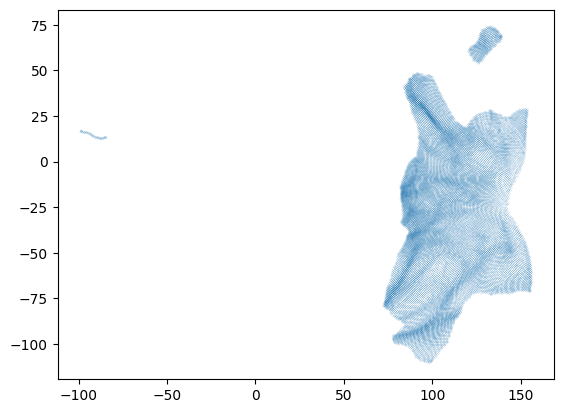

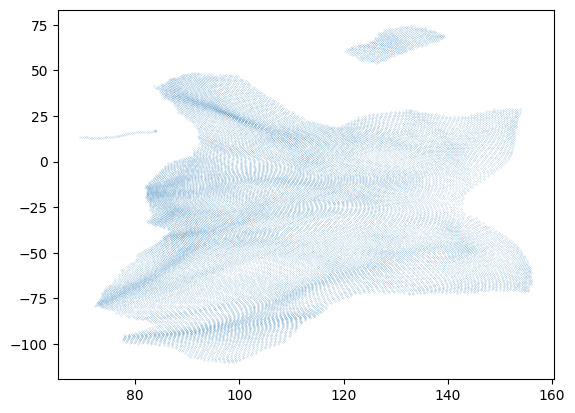

In [634]:
import matplotlib.pyplot as plt

# assuming mappa2d_cut is already defined
x = mappa2d_cut[:, 0]
y = mappa2d_cut[:, 1]

plt.scatter(x, y, s=0.01)
plt.show()

# assuming mappa2d_cut is already defined
x = mappa2d_cut_fix[:, 0]
y = mappa2d_cut_fix[:, 1]

plt.scatter(x, y, s=0.01)
plt.show()

#### 1. 3D Surface mesh to 2D (1. delete third column and 2. Select challenge space vertices)

New arrays with deleted thirds columns

In [643]:
flat_surfaces_2D = {}
hemisphere = 'left'
flat_surfaces_2D[hemisphere[0]+"h"] = np.delete(flat_surfaces[hemisphere[0]+"h"][0], 2, axis=1)[fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1]
hemisphere = 'right'
flat_surfaces_2D[hemisphere[0]+"h"] = np.delete(flat_surfaces[hemisphere[0]+"h"][0], 2, axis=1)[fsaverage_all_vertices[f'{hemisphere[0]}h'] == 1]


Breve esplorazione

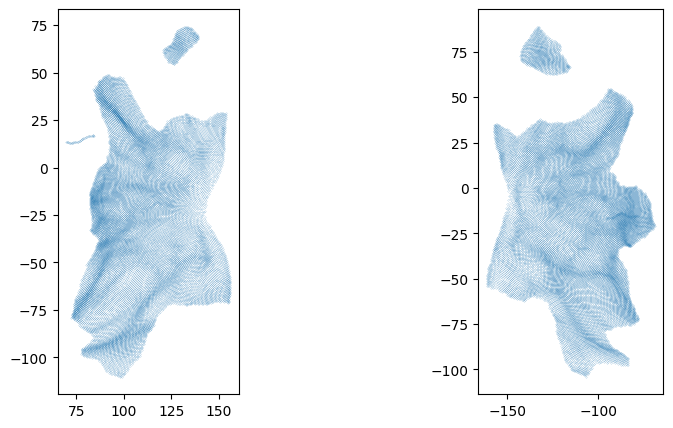

In [797]:
hemisphere = 'left'
x = flat_surfaces_2D[hemisphere[0]+"h"][:, 0]
y = flat_surfaces_2D[hemisphere[0]+"h"][:, 1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(x, y, s=0.01)
axs[0].axes.set_aspect('equal')

hemisphere = 'right'
x = flat_surfaces_2D[hemisphere[0]+"h"][:, 0]
y = flat_surfaces_2D[hemisphere[0]+"h"][:, 1]

axs[1].scatter(x, y, s=0.01)
axs[1].axes.set_aspect('equal')

plt.show()

In [ ]:
hemisphere = 'left'
df_2d = pd.DataFrame(flat_surfaces_2D[hemisphere[0]+"h"], columns=['x', 'y'])
df_2d.index = ['v{}'.format(i+1) for i in range(len(df_2d))]
df_2d.sort_values(by='x', inplace=True)
df_2d.head()

#### 2. Fix Left Hemisphere (no-zero third coordinate)

In [644]:
hemisphere = 'left'
flat_surfaces_2D[hemisphere[0]+"h"][flat_surfaces_2D[hemisphere[0]+"h"][:, 0] < 0, 0] += 15
flat_surfaces_2D[hemisphere[0]+"h"][:, 0] *= np.sign(flat_surfaces_2D[hemisphere[0]+"h"][:, 0])

#### 3. Convert Coordinates 2D map to 2D image (where each pixel is a vertex)

In [712]:
def righe_uguali_arrotondate(array):
    # Arrotonda i valori dell'array alla prima cifra decimale
    array_arrotondato = np.round(array, decimals=1)
    #array_arrotondato = np.round(array/2.0, decimals=1) * 2.0
    
    # Verifica se ci sono righe duplicate nell'array arrotondato
    unq, count = np.unique(array_arrotondato, axis=0, return_counts=True)
    
    return unq[count>1], count[count>1]

In [732]:
print(righe_uguali_arrotondate(flat_surfaces_2D[hemisphere[0]+"h"]))

(array([], shape=(0, 2), dtype=float32), array([], dtype=int64))


In [843]:
# Trova le coordinate minime e massime dei punti
def discretize_points(points, resolution=0.5):
    min_x, min_y = np.min(flat_surfaces_2D[hemisphere[0]+"h"], axis=0)
    max_x, max_y = np.max(flat_surfaces_2D[hemisphere[0]+"h"], axis=0)

    # Calcola il numero di righe e colonne necessarie
    num_cells_y = int(np.ceil((max_y - min_y) / resolution)) + 1
    num_cells_x = int(np.ceil((max_x - min_x) / resolution)) + 1

    # Print the number of rows and columns
    print("Height: {} cells".format(num_cells_y), "Width: {} cells".format(num_cells_x))
    print("Min x value: {} cells".format(min_x), "Max x value: {} cells".format(max_x))
    print("Min y value: {} cells".format(min_y), "Max y value: {} cells".format(max_y))
    
    # Create an empty matrix to store the discretized values
    output_matrix = np.full((num_cells_y, num_cells_x), np.nan)
    count_duplicati = 0
    for i, point in enumerate(flat_surfaces_2D[hemisphere[0]+"h"]):
        x = int((point[0] - min_x) / resolution)
        y = int((point[1] - min_y) / resolution)
        if np.isnan(output_matrix[y, x]):
            # La cella è libera, assegna il punto direttamente
            output_matrix[y, x] = i
        else:
            count_duplicati += 1
            # La cella è occupata, cerca la cella libera più vicina
            radius = 1
            found_cell = False

            while not found_cell:
                for dx in range(-radius, radius + 1):
                    for dy in range(-radius, radius + 1):
                        nx = x + dx
                        ny = y + dy

                        if 0 <= nx < num_cells_x and 0 <= ny < num_cells_y and np.isnan(output_matrix[ny, nx]):
                            x = nx
                            y = ny
                            found_cell = True
                            break

                    if found_cell:
                        break

                radius += 1

            output_matrix[y, x] = i
    
    print(f"Number of relocated duplicates: {count_duplicati}")
    # Invert y axis to match the image coordinate frame
    return np.flip(output_matrix, axis=0)
    

In [844]:
flat_surface_image = {}
hemisphere = 'left'
flat_surface_image[hemisphere[0]+"h"] = discretize_points(flat_surfaces_2D[hemisphere[0]+"h"], 0.5)
hemisphere = 'right'
flat_surface_image[hemisphere[0]+"h"] = discretize_points(flat_surfaces_2D[hemisphere[0]+"h"], 0.5)

Height: 370 cells Width: 175 cells
Min x value: 69.44580841064453 cells Max x value: 156.01158142089844 cells
Min y value: -110.20407104492188 cells Max y value: 74.13507080078125 cells
Number of relocated duplicates: 2010
Height: 387 cells Width: 187 cells
Min x value: -161.478271484375 cells Max x value: -68.652587890625 cells
Min y value: -104.07136535644531 cells Max y value: 88.83477783203125 cells


Number of relocated duplicates: 1523


Check number of non-nan and unique values (they bust be the same of the number of vectors)

In [815]:
for hemisphere in ['left', 'right']:
    print(np.count_nonzero(~np.isnan(flat_surface_image[hemisphere[0]+"h"])))
    print(len(np.unique(flat_surface_image[hemisphere[0]+"h"])))

19004
19005
20544
20545


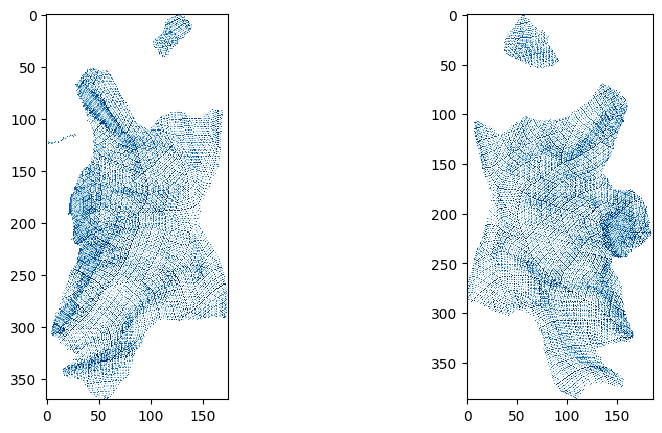

In [859]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

hemisphere = 'left'
axs[0].imshow(flat_surface_image[hemisphere[0]+"h"], cmap="Blues", interpolation='nearest')
hemisphere = 'right'
axs[1].imshow(flat_surface_image[hemisphere[0]+"h"], cmap="Blues", interpolation='nearest')

plt.show()

Explore the matrix

In [850]:
df_test_image = pd.DataFrame(flat_surface_image['lh'])

#### 4. Substitute index in Surface Matrix with other stats (e.g. activations)

Es. substitute with activations

Importo attivazioni

In [816]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

Function to convert indeces matrix to activation matrix

In [841]:
def index_surface_to_stat_surface(index_surface, stat_vector):
    rows, cols = index_surface.shape
    new_matrix_2d = np.full((rows, cols), np.nan)
    
    for i in range(rows):
        for j in range(cols):
            if not np.isnan(index_surface[i, j]):
                index = int(index_surface[i, j])
                new_matrix_2d[i, j] = stat_vector[index]
                
    return new_matrix_2d

In [849]:
flat_surface_image_activations = {}
hemisphere = 'left'
flat_surface_image_activations[hemisphere[0]+"h"] = index_surface_to_stat_surface(flat_surface_image[hemisphere[0]+"h"], lh_fmri[0])
hemisphere = 'right'
flat_surface_image_activations[hemisphere[0]+"h"] = index_surface_to_stat_surface(flat_surface_image[hemisphere[0]+"h"], rh_fmri[0])

In [848]:
data_test = pd.DataFrame(flat_surface_image_activations[hemisphere[0]+"h"])

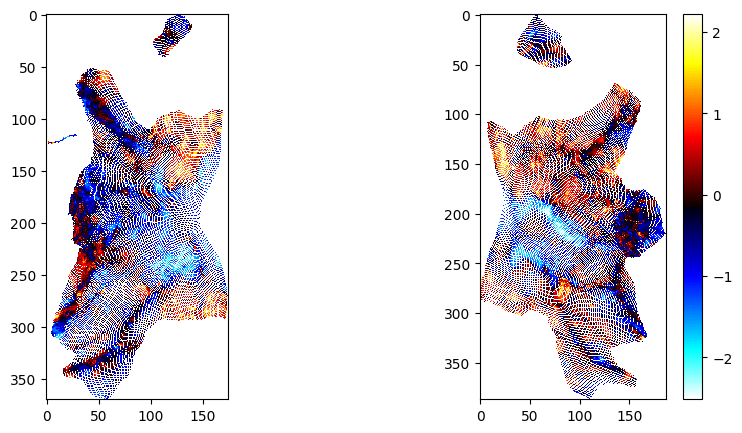

In [867]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

hemisphere = 'left'
im1 = axs[0].imshow(flat_surface_image_activations[hemisphere[0]+"h"], cmap='cold_hot', interpolation='none')
hemisphere = 'right'
img2 = axs[1].imshow(flat_surface_image_activations[hemisphere[0]+"h"], cmap='cold_hot', interpolation='none')
fig.colorbar(img2)
plt.show()

####  3F: Test falliti

In [779]:
from scipy.spatial.distance import cdist
count_duplicati = 0
for i, point in enumerate(flat_surfaces_2D[hemisphere[0]+"h"]):
    x = int((point[0] - min_x) / 0.5)
    y = int((point[1] - min_y) / 0.5)
    if np.isnan(output_matrix[y, x]):
        # La cella è libera, assegna il punto direttamente
        output_matrix[y, x] = i
    else:
        count_duplicati += 1
        # La cella è occupata, cerca la cella libera più vicina
        radius = 1
        found_cell = False

        while not found_cell:
            for dx in range(-radius, radius + 1):
                for dy in range(-radius, radius + 1):
                    nx = x + dx
                    ny = y + dy

                    if 0 <= nx < num_cells_x and 0 <= ny < num_cells_y and np.isnan(output_matrix[ny, nx]):
                        x = nx
                        y = ny
                        found_cell = True
                        break

                if found_cell:
                    break

            radius += 1

        output_matrix[y, x] = i

In [780]:
count_duplicati

2010

In [ ]:
output_matrix

In [781]:
data_test = pd.DataFrame(output_matrix)

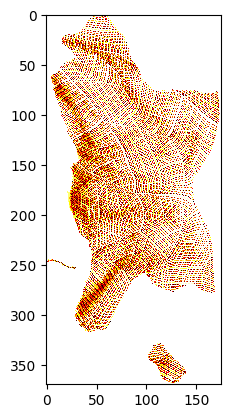

361190025


In [782]:
import matplotlib.pyplot as plt
plt.imshow(output_matrix, cmap='hot', interpolation='nearest')
# find the number of value non -1
plt.show()

print(np.count_nonzero(matirce2d != -1))

In [723]:
len(flat_surfaces_2D[hemisphere[0]+"h"])

array([-20.87566 ,  68.66379 ,  17.8474  , ..., -87.942   , -88.658104,
       -87.95613 ], dtype=float32)

In [717]:
len(np.arange(0, len(flat_surfaces_2D[hemisphere[0]+"h"]), 1))

19004

In [730]:
from scipy.sparse import coo_matrix
def discretize_points(points, resolution):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Calculate the number of cells in the grid
    num_cols = int((max_x - min_x) / resolution) + 1
    num_rows = int((max_y - min_y) / resolution) + 1

    # Calculate the column and row indices for each point
    col_indices = ((points[:, 0] - min_x) / resolution).astype(int)
    row_indices = ((points[:, 1] - min_y) / resolution).astype(int)

    # Calculate the flattened indices for the COO matrix
    indices = np.ravel_multi_index((row_indices, col_indices), (num_rows, num_cols))

    # Create the COO matrix
    data = np.arange(len(points))
    grid = coo_matrix((data, (indices, indices)), shape=(num_rows, num_cols))

    # Convert the COO matrix to a dense array
    grid = grid.toarray()

    return grid

In [ ]:
discretized_grid = discretize_points(flat_surfaces_2D[hemisphere[0]+"h"], 0.5)

In [679]:
grid = np.full((num_rows, num_cols), -9999, dtype=int)
grid.shape

(1845, 867)

In [672]:
print(min_x, min_y)
print(max_x, max_y)

69.44581 -110.20407
156.01158 74.13507


In [675]:
import numpy as np

def create_grid(points):
    # Trova le coordinate minime e massime dei punti
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Calcola il numero di righe e colonne necessarie
    num_rows = int(np.ceil((max_y - min_y) / 0.1)) + 1
    num_cols = int(np.ceil((max_x - min_x) / 0.1)) + 1

    # Crea la matrice di output inizializzata a -9999
    grid = np.full((num_rows, num_cols), -9999, dtype=int)

    # Calcola gli indici delle celle corrispondenti ai punti
    indices = ((points - np.array([min_x, min_y])) / 0.01).astype(int)

    # Assegna gli indici dei punti alle celle corrispondenti
    for i, (row, col) in enumerate(indices):
        if grid[row, col] == -9999:
            grid[row, col] = i
        else:
            # Se la cella è già occupata, cerca la cella vuota più vicina
            dist = 1
            while True:
                # Controlla le celle intorno alla cella corrente
                for r in range(row - dist, row + dist + 1):
                    for c in range(col - dist, col + dist + 1):
                        if 0 <= r < num_rows and 0 <= c < num_cols and grid[r, c] == -9999:
                            grid[r, c] = i
                            return grid  # Termina la funzione dopo aver assegnato il punto

                # Incrementa la distanza di ricerca
                dist += 1

    return grid


In [ ]:
grid = create_grid(flat_surfaces_2D[hemisphere[0]+"h"])

In [18]:
def create_spatial_matrix(points):
    # Trova i valori massimi e minimi delle coordinate x e y
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    # Calcola il numero di righe e colonne per la matrice
    num_rows = int(max_y - min_y + 1)
    num_cols = int(max_x - min_x + 1)

    # Crea una matrice vuota con valori -1 per indicare le celle non assegnate
    spatial_matrix = np.full((num_rows, num_cols), -1, dtype=int)

    # Assegna gli indici dei punti alle celle corrispondenti
    for i, point in enumerate(points):
        x, y = point
        row = int(y - min_y)
        col = int(x - min_x)
        spatial_matrix[row, col] = i

    return spatial_matrix

In [43]:
def to_matrix(points):
    # Create grids for x and y axes
    X, Y = np.linspace(min(points[:, 0]), max(points[:, 0]), num=5), np.linspace(min(points[:, 1]), max(points[:, 1]), num=5)
    
    # Find indices of all points in grid
    print(X, Y)
    X_idx = np.max(np.abs(X - points[:, 0]))
    Y_idx = np.max(np.abs(Y - points[:, 1]))
    
    # Flatten indices into single array
    idx = np.ravel_multi_index((X_idx, Y_idx), (len(X), len(Y)))
    return idx.reshape(-1, )

In [ ]:
x_coords = mappa2d_cut[:, 0]
y_coords = mappa2d_cut[:, 1]

# Find the minimum and maximum x and y coordinates
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

# Define the desired size of the 2D matrix
matrix_size = (int(x_max - x_min + 1), int(y_max - y_min + 1))

# Create a grid of indices corresponding to the points array
indices = np.arange(mappa2d_cut.shape[0]).reshape(matrix_size)

# Create the x and y coordinate grids using np.meshgrid
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))

# Initialize the output matrix with -1 (or any other appropriate default value)
output_matrix = np.full(matrix_size, -1)

# Iterate over the x and y coordinate grids
for x, y, idx in zip(x_coords, y_coords, indices.flatten()):
    # Calculate the corresponding indices in the output matrix
    i, j = int(x - x_min), int(y - y_min)
    # Assign the index to the corresponding cell in the output matrix
    output_matrix[i, j] = idx

print(output_matrix)

In [88]:
np.linspace(0.01, 1.00, 10)

array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])

In [101]:
matrirce2d = to_matrix_1(mappa2d_cut)

In [102]:
matirce2d.shape

(19005, 19005)

In [ ]:
matirce2d[:10]

In [66]:
# print the number of non nan values in the matrix
print(np.count_nonzero(~np.isnan(matrirce2d)))
print(19005*19005)

361190025
361190025


In [ ]:
len(to_matrix(mappa2d_cut))

In [24]:
len(mappa2d_cut)

19004

In [19]:
matirce2d = create_spatial_matrix(mappa2d_cut)

In [ ]:
# print unique values in the array and their frequency
unique, counts = np.unique(matirce2d, return_counts=True)
print(np.asarray((unique, counts)).T[:10])

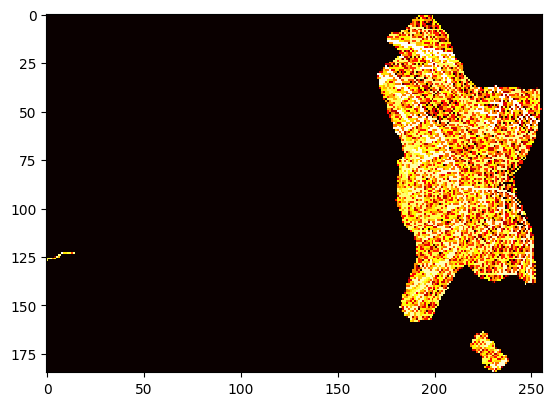

8356


In [23]:
import matplotlib.pyplot as plt
plt.imshow(matirce2d, cmap='hot', interpolation='nearest')
# find the number of value non -1
plt.show()

print(np.count_nonzero(matirce2d != -1))


In [40]:
matirce2d = create_spatial_matrix(mappa2d_cut)

In [39]:
def create_spatial_matrix(points):
    # Trova i valori massimi e minimi delle coordinate x e y
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    # Calcola il numero di punti e crea una matrice vuota
    num_points = len(points)
    spatial_matrix = np.full((num_points, num_points), -1, dtype=int)

    # Assegna gli indici dei punti alle celle corrispondenti
    for i, point in enumerate(points):
        x, y = point
        row = int(y - min_y)
        col = int(x - min_x)
        spatial_matrix[row, col] = i

    return spatial_matrix

In [37]:
mappa3d = surface.load_surf_data(fsaverage['infl_'+hemisphere])

In [34]:
# explore mappa shape
print(mappa3d[0].shape)
print(mappa3d[1].shape)

(163842, 3)
(327680, 3)


In [ ]:
mappa3d[0][:10]	

In [117]:
to_plot = mappa2d[0][fsaverage_all_vertices == 1] # [fsaverage_roi == 1]
len(to_plot)

19004

In [ ]:
import plotly.graph_objs as go
import numpy as np

# Assuming the selected array is stored in the variable 'selected_array'
x = to_plot[:,0]
y = to_plot[:,1]
z = to_plot[:,2]
colors = np.random.rand(len(to_plot))
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=colors, size=0.5))])
fig.show()

In [106]:
import numpy as np

# Generate some random points
points = np.random.rand(10, 2)
print(points)

# Define the size of the grid
grid_size = (5, 5)

# Create the 2D grid of coordinates
x_coords = np.linspace(0, 1, grid_size[0])
y_coords = np.linspace(0, 1, grid_size[1])
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
grid_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

# Find the closest point in the original array for each cell in the grid
distances = np.linalg.norm(grid_points[:, None, :] - points[None, :, :], axis=2)
indices = np.argmin(distances, axis=1)

# Create the 2D matrix
matrix = np.reshape(indices, grid_size)

# Print the matrix
print(matrix)

[[0.91052815 0.30187219]
 [0.33578122 0.43580837]
 [0.61963139 0.91417424]
 [0.01010645 0.8935848 ]
 [0.95527355 0.39480206]
 [0.49944735 0.07308536]
 [0.96253169 0.08812601]
 [0.6635946  0.47654991]
 [0.37552867 0.69300979]
 [0.52723466 0.43682815]]
[[5 5 5 6 6]
 [1 1 5 0 0]
 [1 1 9 7 4]
 [3 8 8 2 4]
 [3 3 2 2 2]]


In [110]:
import numpy as np

# Generate some random points
points = np.random.rand(10, 2)
print(points)

# Define the size of the grid
grid_size = (5, 5)

# Create the 2D grid of coordinates
x_coords = np.linspace(0, 1, grid_size[0])
y_coords = np.linspace(0, 1, grid_size[1])
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
print(x_grid, y_grid)
grid_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

# Find the closest point in the original array for each cell in the grid
distances = np.linalg.norm(grid_points[:, None, :] - points[None, :, :], axis=2)
indices = np.argmin(distances, axis=1)

# Create the 2D matrix
matrix = np.full(grid_size, np.nan)
mask = np.zeros(grid_size, dtype=bool)
mask[np.unravel_index(indices, grid_size)] = True
matrix[mask] = np.arange(len(points))

# Print the matrix
print(matrix)

[[0.18586942 0.95877321]
 [0.40444645 0.35261865]
 [0.07397121 0.8733612 ]
 [0.57391517 0.94197607]
 [0.4116796  0.1309717 ]
 [0.39767401 0.59014919]
 [0.74612897 0.42979978]
 [0.60159064 0.8012517 ]
 [0.09413276 0.63235499]
 [0.43266647 0.06613451]]
[[0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]] [[0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.25]
 [0.5  0.5  0.5  0.5  0.5 ]
 [0.75 0.75 0.75 0.75 0.75]
 [1.   1.   1.   1.   1.  ]]
[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


# Model Fit

In [4]:
train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader = data_loaders.images_dataloader(batch_size, transform)

model, feature_extractor = model_loader(feature_model_type, model_layer, device)

# Fit the PCA model
pca_batch_size, n_stacked_batches = pca_batch_calculator(len(idxs_train),
                                                            batch_size,
                                                            min_pca_batch_size,
                                                            pca_component)
pca = fit_pca(feature_extractor,
                train_imgs_dataloader,
                pca_component,
                n_stacked_batches,
                pca_batch_size,
                device)
print("Comulative Explained variance ratio: ", sum(pca.explained_variance_ratio_))
print("Number of components: ", pca.n_components_)

print('## Extracting features from training, validation and test data...')
features_train = extract_and_pca_features(feature_extractor, train_imgs_dataloader, pca, n_stacked_batches, device)
features_val = extract_and_pca_features(feature_extractor, val_imgs_dataloader, pca, n_stacked_batches, device)
features_test = extract_and_pca_features(feature_extractor, test_imgs_dataloader, pca, n_stacked_batches, device)

# print("\n")
# print('## Checking and Freeing  GPU memory...')
# memory_checker()
model.to('cpu') # sposto sulla ram
feature_extractor.to('cpu') # sposto sulla ram
del model, feature_extractor, pca, train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader  # elimino dalla ram
torch.cuda.empty_cache() # elimino la chache vram
gc.collect() # elimino la cache ram
# memory_checker()

## Loading feature extraction model...


Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0




Feature extractor: alexnet, layer: features.2


## Calculating PCA batch size...
Batches size: 64
Total train instances: 8857
PCA components: 512
Minimum pca batch size: 1024
Number of stacked batches for pca: 20
PCA batch size (batch_size * n_stacked_batches): 1280
Last pca batch size: 1177
## Fitting Incremental PCA (512 components) to training data...


 86%|████████▌ | 119/139 [05:03<00:16,  1.18it/s]

# Grid Search

In [5]:
## Fit the linear model ##
print('\n ## Fit Encoder and Predict...')
lh_fmri_train, lh_fmri_val, rh_fmri_train, rh_fmri_val = data_loaders.fmri_splitter()
print('LH fMRI number of vertices:', lh_fmri_train.shape)
print('RH fMRI number of vertices:', rh_fmri_train.shape)
# param_grid = {'alpha': [0.0001, 0.0002, 0.001, 0.01, 0.1, 1, 10, 100, 1e3, 5e3, 1e4, 2e4, 5e4, 1e5, 1e6]}

param_grid = {'alpha': [1, 10, 100, 1e3, 5e3, 1e4, 2e4, 5e4, 1e5, 1e6]}


 ## Fit Encoder and Predict...
LH fMRI number of vertices: (8857, 19004)
RH fMRI number of vertices: (8857, 20544)


In [6]:
grid_search_l = GridSearchCV(Ridge(), param_grid=param_grid, scoring=make_scorer(
    lambda x, y: np.median(compute_perason_numpy(x, y))), cv=5, n_jobs=5, verbose=1)
grid_search_l.fit(X=features_train, y=lh_fmri_train)
print("Best Param: {}".format(grid_search_l.best_params_))
print("Best Score: {}".format(grid_search_l.best_score_))
alpha_l = grid_search_l.best_params_['alpha']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Param: {'alpha': 20000.0}
Best Score: 0.4178484288672604


In [7]:
grid_search_r = GridSearchCV(Ridge(), param_grid=param_grid, scoring=make_scorer(
    lambda x, y: np.median(compute_perason_numpy(x, y))), cv=5, n_jobs=5, verbose=1)
grid_search_r.fit(X=features_train, y=rh_fmri_train)
print("Best Param: {}".format(grid_search_r.best_params_))
print("Best Score: {}".format(grid_search_r.best_score_))
alpha_r = grid_search_r.best_params_['alpha']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Predict

In [ ]:
lh_fmri_val_pred, lh_fmri_test_pred, rh_fmri_val_pred, rh_fmri_test_pred = linear_regression(regression_type, 
                                                                                                features_train, 
                                                                                                features_val, 
                                                                                                features_test, 
                                                                                                lh_fmri_train, 
                                                                                                rh_fmri_train, 
                                                                                                save_predictions,
                                                                                                args.subject_submission_dir,
                                                                                                alpha_l,
                                                                                                alpha_r,
                                                                                                grid_search= False)

Fitting linear regressions on the training data...
Predicting fMRI data on the validation and test data...
Computing the correlation between the predicted and actual fMRI data...


100%|██████████| 20544/20544 [00:03<00:00, 6549.68it/s]



 Score -> Median Noise Normalized Squared Correlation Percentage (LH and RH)
LH subj 1 | Score:  43.43462272034031
RH subj 1 | Score:  42.380407505909844


# Evaluate and Visualize

In [ ]:
noise_norm_corr_dict[f'lh_{subj}'], noise_norm_corr_dict[f'rh_{subj}'] = median_squared_noisenorm_correlation(lh_fmri_val_pred, 
                                                                                                                rh_fmri_val_pred,
                                                                                                                lh_fmri_val,
                                                                                                                rh_fmri_val,
                                                                                                                args.data_dir,
                                                                                                                args.ncsnr_dir,
                                                                                                                args.images_trials_dir,
                                                                                                                idxs_val)
print("\n Score -> Median Noise Normalized Squared Correlation Percentage (LH and RH)")
print("LH subj",subj,"| Score: ",np.median(noise_norm_corr_dict[f'lh_{subj}'])*100)
print("RH subj",subj,"| Score: ",np.median(noise_norm_corr_dict[f'rh_{subj}'])*100)

In [6]:
histogram(args.data_dir, noise_norm_corr_dict[f'lh_{subj}'], 
          noise_norm_corr_dict[f'rh_{subj}'], 
          submission_name, 
          save = args.subject_images_submission_dir)



c:\Users\giorg\miniconda3\envs\algonauts\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giorg\miniconda3\envs\algonauts\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
box_plot(args.data_dir, noise_norm_corr_dict[f'lh_{subj}'], 
          noise_norm_corr_dict[f'rh_{subj}'], 
          submission_name, 
          save = args.subject_images_submission_dir)